In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import warnings
warnings.filterwarnings("ignore")

NETFLIX_PATH = r'/Users/Alexandre/Documents/ML/Cambridge Spark docs/netflix_titles.csv'

data = pd.read_csv(NETFLIX_PATH)

In [19]:
# Cursory look at data

data.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


I'd like to start exploring with pair plot but in this case most data are not numerical. I am peersonally interested in the numerical data.

There are 12 columns with DF length of 8807. Only 'director', 'cast', 'country', 'rating' & 'duration' have null values. Since the latter is the only (ostensibly) numerical of these, only this is to be imputed. However, duration is listed as object type, so this will need to be looked at.

First, notice that 'rating' contains some incorrect data:

In [27]:
data.rating.unique()

array(['PG-13', 'TV-MA', 'PG', 'TV-14', 'TV-PG', 'TV-Y', 'TV-Y7', 'R',
       'TV-G', 'G', 'NC-17', '74 min', '84 min', '66 min', 'NR', nan,
       'TV-Y7-FV', 'UR'], dtype=object)

Some data from the duration feeature has made its way here. Here's a function to move those and take car of the same issue in future:

In [ ]:
# functions for cleaning
def rate_fix(df):
    for i in df.index:
        x = df.at[i, 'rating']
        if isinstance(x, str) and x.split()[-1] in ['min','Season']:
            parts = x.split()
            if parts[-1] == 'min':
                df.at[i, 'duration'] = x
                df.at[i, 'rating'] = 'Unknown'
        elif type(x)==np.nan:
            df.at[i, 'rating'] = 'Unknown'
        else:
            pass

In [ ]:
def rate_fix(df):
    for i in df.index:
        x = df.at[i, 'rating']
        if isinstance(x, str) and x.split()[-1] in ['min','Season']:
            parts = x.split()
            if parts[-1] == 'min':
                df.at[i, 'duration'] = x
                df.at[i, 'rating'] = 'Unknown'
        elif type(x)==np.nan:
            df.at[i, 'rating'] = 'Unknown'
        else:
            pass

This moves the incorrect 'rating' data to 'duration' and also replaces NaNs with 'Unknown' while its at it.

Next, peak at 'duration'.

In [31]:
data.duration.values

array(['90 min', '2 Seasons', '1 Season', ..., '88 min', '88 min',
       '111 min'], dtype=object)

We see TV shows have 'N seasons' and films 'N mins', as strings. Here's a function that converts these to just N as integers:

In [32]:
def dur_fix(string):
  if type(string)==str and string.split(' ')[-1] in ['min','Season','Seasons']:
    return int(string.split(' ')[0])
  else:
    return np.nan

which is used with .apply() on the dataframe. NaNs are kept because this is now a numeric columns. 

Using these:


In [33]:
df = data.copy()

rate_fix(df)
df.duration = df.duration.apply(dur_fix)

## Analysing duration

In order to look at this, it makes sense frst to separate the data into TV and film, since their duration data live in different domains.

In [76]:
movie_df = df[df.type=='Movie']
tv_df = df[(df.type=='TV Show') & (df.release_year>=1950)]

I have chosen to exclude earlier shows because I believe the data to be unreliable. For instance, the earliest show in the date has release_year 1925 but this is clearly a mistake. In any case, television did not become widespread until the 1950s.

In [78]:
tv_df.duration.sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 15, 17])

There are some beloved classics with a higher number of seasons here, with *Grey's Anatomy* taking the lead with a whopping 17 seasons.

'Pioneers: First Women Filmmakers*'

#### TV shows and their durations (no. seasons) over time

We'll group by ```release_year``` and seee if we spot any crude trends in the median numbeer of seasons.

Text(0.5, 0, 'Release year')

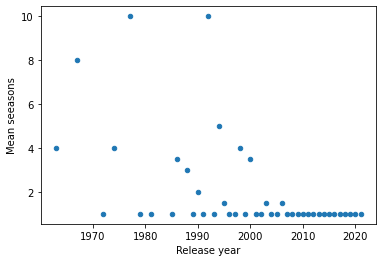

In [93]:
tv_df.groupby('release_year')[['duration']].median().reset_index().plot(kind='scatter',x='release_year',y='duration');
plt.ylabel('Mean seeasons')
plt.xlabel('Release year')

It stands to reason that as we come closer to the present day we are going to see fewer TV series with a higher number of seasons, but looking even before 2010, there is no real trend.

However, we can say this: Higher median seasons occurs for shows that premier in thee 1970s and 1990s, and generally those from the 90s had more seasons than now. The 21st century epoch appears to be one of single-season shows, but this may be a Netflix-only issue.

One thing to be aware of is that the data is moree skews thee further we go back. This is because the samples aree smaller, as can be seen by a simple count:

Text(0.5, 0, 'Release year')

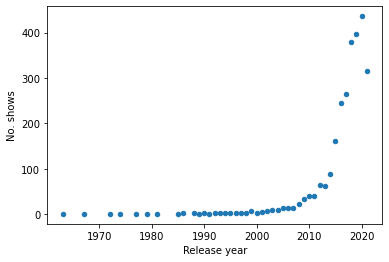

In [92]:
tv_df.groupby('release_year')[['title']].count().reset_index().plot(kind='scatter',x='release_year',y='title');
plt.ylabel('No. shows')
plt.xlabel('Release year')

There is a large amount of samples for the past ten years, lending accuracy to our observation that, so far, the 21th century shows little sign of breaking past the mean season number of 1. (The 20th century median is also 1, but clearly there is more variation from year to year.)

## Films and their runtimes over time

This sector of the data should bee more interesting since film runtimes are far more continuous in nature.

We'll again group by ```release_year```. Taking a hint from our analysis of TV 'durations', lets look at a bare count of runtimes.

Text(0, 0.5, 'No. films')

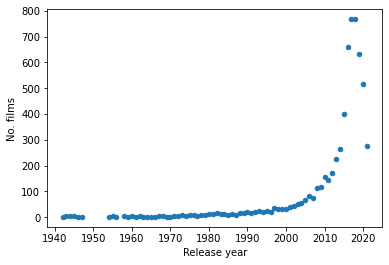

In [100]:
(
  movie_df.groupby('release_year')['title']
  .count()
  .reset_index()
  .plot(kind='scatter',x='release_year',y='title')
);
plt.xlabel('Release year')
plt.ylabel('No. films')

We again see there are a lot more films being created/included on Netflix in the past decade or so. 

One thing that stands out is that, as with TV, the peak years of movie releases aree actually 2017/18, a few years before COVID (which might be eexpected to directly follow the peak year). This suggests that either, 1) there was a surge in films being released during this priod which subsequently ran out of steam, or 2) the years 2018-2020 saw lower-than-expected releases, if the previous trend were to continue.

Either of these scenarios could point to interesting further investigations.

Moving on, what the release counts tell us is that more recent data will be more accurate statistically because of larger sample numbers.

Before we look at film durations by year, we should ask ourselves what we might expect to see. I and many peeople I know are of the opinion that films are getting longer and longer, with the classic 90 minute runtime giving way to 2 and half/3 hour long films. Let's see if this this matches the data.


The mean film duration before 1990 is  116.13191489361702
Peak count year was  2017


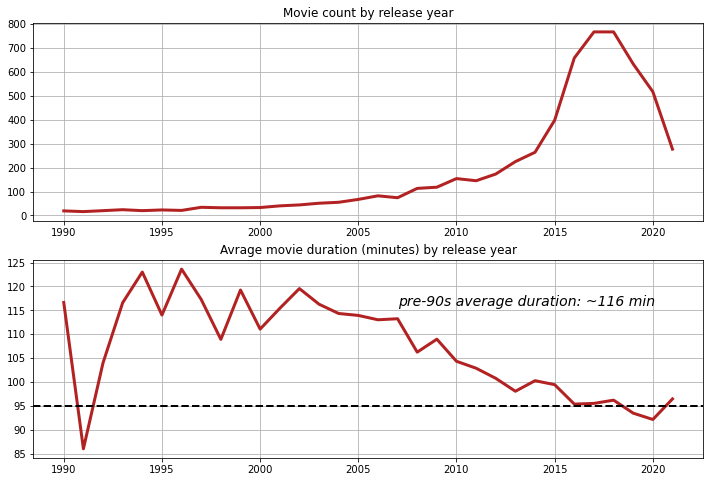

In [101]:
new_movies = movie_df[movie_df.release_year>=1990]
old_movies = movie_df[movie_df.release_year<1990]


print('The mean film duration before 1990 is ',old_movies.duration.mean())
# baseline mean before 1990


fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 8)) 

(
  new_movies.groupby('release_year')[['title']]
  .count()
  .reset_index()
  .plot(kind='line',x='release_year',y='title',ax=ax[0],label='All titles',color='firebrick', linewidth=3)
)
ax[0].set_xlabel('')
ax[0].set_title('Movie count by release year')
ax[0].grid(True,which='both')
ax[0].get_legend().remove()



print('Peak count year was ',new_movies.groupby('release_year')[['title']].count().idxmax().item())
# 

(
  new_movies.groupby('release_year')[['duration']]
  .mean()
  .reset_index()
  .plot(kind='line',x='release_year',y='duration',ax=ax[1],color='firebrick', linewidth=3)
)
ax[1].set_xlabel('')
ax[1].set_title('Avrage movie duration (minutes) by release year')
ax[1].grid(True,which='both')
ax[1].get_legend().remove()
ax[1].text(2007, 116, 'pre-90s average duration: ~116 min', fontsize=14, color='black',fontstyle='italic', fontweight='ultralight')
ax[1].axhline(y=95, color='black', linestyle='--', linewidth=2);
 

I've focussed on the 90s onward to get more reliable figures. Surprisingly (to me!), film durations are trending back to the 90-minute mark. 

#### Decreasing film run times: a general trend?

Perhaps my perceptions are based on English language (that is to. say, predominantly Amrican) films. If we talk US films to be those whose ```country``` is solely ```'United States'```, then non-US production outnumber US productions by about 2 to 1.

Using this (admitly crude) criterior for 'US' and 'rest of world' (RoW), we split the dataset.

In [102]:
us_movies = movie_df[movie_df.country=='United States']
row_movies = movie_df[movie_df.country!='United States']

Here's how they compare:

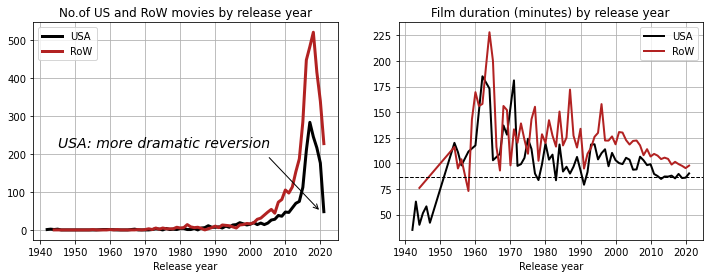

In [104]:
# Create a figure and a set of subplots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4)) 

(
  us_movies.groupby('release_year')[['title']]
  .count()
  .reset_index()
  .plot(kind='line',x='release_year',y='title',label='USA',ax=axs[0],color='black', linewidth=3)
)

(
  row_movies.groupby('release_year')[['title']]
  .count()
  .reset_index()
  .plot(kind='line',x='release_year',y='title',label='RoW',ax=axs[0],color='firebrick', linewidth=3)
)
axs[0].set_title('No.of US and RoW movies by release year')
axs[0].set_xlabel('Release year')
axs[0].grid(True,which='both')
# axs[0].text(1945, 360, 'RoW: higher \'creative burst?\'', fontsize=14, color='black',fontstyle='italic', fontweight='ultralight')
axs[0].text(1945, 220, 'USA: more dramatic reversion', fontsize=14, color='black',fontstyle='italic', fontweight='ultralight')

# axs[0].annotate('', xy=(2016, 520), xytext=(2005, 400),
#              arrowprops=dict(facecolor='black', arrowstyle="->"),
#              fontsize=12, color='black')
axs[0].annotate('', xy=(2020, 50), xytext=(2005, 195),
             arrowprops=dict(facecolor='black', arrowstyle="->"),
             fontsize=12, color='black')

# 

(
  us_movies.groupby('release_year')[['duration']]
  .mean()
  .reset_index()
  .plot(kind='line',x='release_year',y='duration',label='USA',ax=axs[1],color='black', linewidth=2)
)
(
  row_movies.groupby('release_year')[['duration']]
  .mean()
  .reset_index()
  .plot(kind='line',x='release_year',y='duration',label='RoW',ax=axs[1],color='firebrick', linewidth=2)
)
axs[1].set_title('Film duration (minutes) by release year')
axs[1].set_xlabel('Release year')
axs[1].grid(True)
axs[1].axhline(y=87, color='black', linestyle='--', linewidth=1);

Both sectors of origin experience the same precipitous fall in recent years, but with the US peaking earlier (in 2017 as opposed to 2018 for RoW).

In [105]:
print(us_movies.groupby('release_year')[['title']].count().idxmax().item())
print(row_movies.groupby('release_year')[['title']].count().idxmax().item())

2017
2018


Interestingly, the US is lading the trend towards shorter film durations. Clearly it is less well-known/award winning films that are the long ones, and not the multitude.

How could this analysis inform decisions? If films are getting shorter, people do not seem to think it. (Anecdotally, of course. Perhaps some surveys could be done on this.) If theere is a strong prference for shrteer films among adults with less free time, a streaming platform should probably make them awaree of the options out there, perhaps by proving a filter.